<h1 div class='alert alert-success'><center> Tunning Hyperparameters Random Forest
    

 </center></h1>

![](https://storage.googleapis.com/kaggle-competitions/kaggle/26480/logos/header.png?t=2021-04-09-00-57-05)

# <div class="alert alert-success">  1. INSTALAÇÕES </div>

In [ ]:
!pip install --quiet optuna
!pip install --q GPUtil
#!pip install --q pytorch-tabnet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


# <div class="alert alert-success"> 2. IMPORTAÇÕES </div>

## 2.1. Bibliotecas

In [1]:
import warnings
import os
import gc
import random
import glob
import optuna

In [2]:
import pandas               as pd
import numpy                as np
import matplotlib.pyplot    as plt 
import seaborn              as sns
import joblib               as jb

In [3]:
import torch
import torch.nn             as nn

In [4]:
from sklearn.ensemble       import RandomForestClassifier

In [5]:
from sklearn.model_selection       import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing         import QuantileTransformer,  KBinsDiscretizer, StandardScaler
from sklearn.preprocessing         import RobustScaler, MinMaxScaler, MaxAbsScaler
from sklearn                       import metrics
from sklearn.feature_selection     import SelectKBest, SelectPercentile, f_classif

In [6]:
from optuna.samplers               import TPESampler
from optuna.visualization          import plot_edf
from optuna.visualization          import plot_optimization_history
from optuna.visualization          import plot_parallel_coordinate
from optuna.visualization          import plot_param_importances
from optuna.visualization          import plot_slice
from optuna.visualization          import plot_intermediate_values
from optuna.visualization          import plot_contour
from optuna.pruners                import MedianPruner

In [7]:
from GPUtil                        import showUtilization as gpu_usage
from numba                         import cuda
from sklearn.ensemble              import IsolationForest
from psutil                        import virtual_memory
from datetime                      import datetime

## 2.2. Funções

In [8]:
def jupyter_setting():
    
    %matplotlib inline
     
    pd.options.display.max_columns = None
    
    optuna.logging.set_verbosity(optuna.logging.WARNING)
      
    warnings.filterwarnings(action='ignore')
    warnings.simplefilter('ignore')
    warnings.filterwarnings('ignore')
    warnings.filterwarnings('ignore', category=DeprecationWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    warnings.filterwarnings('ignore', category=UserWarning)
    #pd.set_option('display.max_rows', 150)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.max_colwidth', None)

    icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
    #sns.palplot(sns.color_palette(icecream))
    
    return icecream

icecream = jupyter_setting()

In [9]:
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [10]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.rcParams['font.size'] = 12
    plt.title('Precision Recall vs threshold')
    plt.xlabel('Threshold')
    plt.legend(loc="lower left")
    
    plt.grid(True)

In [11]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1], "b-", label="Precision")
    
    plt.rcParams['font.size'] = 12
    plt.title('Precision vs recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # plt.legend(loc="lower left")
    
    plt.grid(True)

In [12]:
def plot_roc_curve(fpr, tpr, label=None):
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, "r-", label=label)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for TPS 09')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc="lower right")
    plt.grid(True)

In [13]:
def graf_corr(df):
    
    df = df.corr().round(5)

    # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
    mask = np.zeros_like(df)
    mask[np.triu_indices_from(mask)] = True

    # Making a plot
    plt.figure(figsize=(16,16))
    ax = sns.heatmap(df, annot=True, mask=mask, cmap="RdBu", annot_kws={"weight": "bold", "fontsize":13})

    ax.set_title("Mapa de calor de correlação das variável", fontsize=17)

    plt.setp(ax.get_xticklabels(), 
             rotation      = 90, 
             ha            = "right",
             rotation_mode = "anchor", 
             weight        = "normal")

    plt.setp(ax.get_yticklabels(), 
             weight        = "normal",
             rotation_mode = "anchor", 
             rotation      = 0, 
             ha            = "right");

In [14]:
def correlation(dataset, threshold):

    col_corr    = set()  # Conjunto de todos os nomes de colunas correlacionadas
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= threshold: # estamos interessados no valor coeficiente absoluto
                colname = corr_matrix.columns[i]        # obtendo o nome da coluna
                col_corr.add(colname)
    
    return col_corr

In [15]:
def free_gpu_cache():
    
    # https://www.kaggle.com/getting-started/140636
    #print("Initial GPU Usage")
    #gpu_usage()                             

    #cuda.select_device(0)
    #cuda.close()
    #cuda.select_device(0)   
    
    gc.collect()
    torch.cuda.empty_cache()

## 2.3. GPU

### 2.3.1. Informações

In [16]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Nov 27 23:39:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.06       Driver Version: 510.06       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   55C    P8    N/A /  N/A |    904MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 2.3.2. Memória

In [17]:
ram_gb = virtual_memory().total / 1e9

print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 17.0 gigabytes of available RAM

Not using a high-RAM runtime


## 2.4. Carregar Dados

In [18]:
path   = '/content/drive/MyDrive/kaggle/Tabular Playground Series/2021/11 - Novembro/'
path   = ''
target = 'target'

In [19]:
df3_train     = jb.load(path + 'Data/pkl/df2_nb_02_train.pkl.z')
df3_test      = jb.load(path + 'Data/pkl/df2_nb_02_test.pkl.z')
df_submission = pd.read_csv(path + 'Data/sample_submission.csv')

df3_train.shape, df3_test.shape, df_submission.shape

((600000, 111), (540000, 110), (540000, 2))

In [20]:
df3_train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,target,fe_cluster_0,fe_cluster_1,fe_cluster_2,fe_cluster_3,fe_cluster_4,fe_mean,fe_median,fe_min,fe_max,fe_skew
0,0.106628,3.593750,132.7500,3.183594,0.081970,1.188477,3.732422,2.265625,2.099609,0.012329,1.607422,-0.318115,0.560059,2.806641,1.351562,2.535156,0.197510,0.676270,1.990234,-3.841797,0.037384,0.230347,3.330078,0.009399,0.144775,3.050781,1.303711,0.033234,-0.018280,2.748047,-0.009293,-0.036285,-0.049866,0.019485,3.898438,11.289062,1.137695,3.367188,4.945312,-0.105774,2.113281,3.453125,0.789551,1.113281,1.491211,2.439453,0.041809,3.355469,0.053680,1.701172,0.908691,0.094910,0.030212,0.597168,4.445312,1.586914,-0.068665,-0.108276,0.061035,0.046112,0.017105,-0.027557,0.019485,-0.048828,0.050751,3.728516,5.015625,4.187500,0.063354,0.121033,1.372070,4.015625,0.167603,0.039764,2.042969,-0.016617,0.107666,3.507812,0.013657,-0.097046,5.394531,0.244507,3.492188,0.113098,-0.015472,4.207031,4.105469,0.037231,-0.118835,0.067078,0.010742,1.098633,0.013329,-0.011719,0.052765,0.065430,4.210938,1.978516,0.085999,0.240479,0,1,0,0,0,0,2.650391,0.242432,-3.841797,132.7500,9.687500
1,0.125000,1.673828,76.5625,3.378906,0.099426,5.093750,1.275391,-0.471436,4.546875,0.037720,0.331787,0.325195,0.062042,2.261719,4.339844,-0.224976,0.233643,3.380859,1.903320,0.067871,-0.051270,0.006134,2.603516,0.103455,0.067627,4.753906,1.855469,-0.181885,0.008362,3.166016,0.011848,0.022293,0.069336,0.117126,0.315186,24.484375,1.671875,-0.409180,4.953125,0.092346,2.603516,1.955078,0.005898,3.289062,2.564453,0.817871,0.026001,4.617188,1.575195,0.066101,0.681641,0.025253,0.183472,0.110046,2.746094,0.835449,0.188232,4.960938,0.136108,-0.008492,-0.015266,-0.010841,0.064575,0.102539,0.093628,0.963867,0.630371,4.308594,0.091309,-0.036346,3.617188,3.103516,0.000657,0.051300,1.924805,0.123291,-0.022675,1.547852,-0.010399,0.058319,3.662109,-0.118408,2.357422,-0.009109,0.178711,4.097656,3.533203,0.005245,0.121399,0.109985,0.135864,3.460938,0.017059,0.124878,0.154053,0.606934,-0.267822,2.578125,-0.020874,0.024719,0,1,0,0,0,0,2.136719,0.145020,-0.471436,76.5625,8.429688
2,0.036316,1.497070,233.5000,2.195312,0.026917,3.126953,5.058594,3.849609,1.801758,0.057007,0.328613,2.968750,0.105225,2.070312,5.308594,1.354492,-0.261963,1.378906,1.480469,0.020538,-0.008804,0.109375,1.683594,0.038177,0.123718,1.112305,3.572266,0.120605,0.082092,2.234375,0.002270,0.045197,0.014404,0.011597,-0.502930,33.750000,1.417969,1.071289,3.222656,2.121094,3.082031,0.637695,-0.006821,-0.390869,17.343750,3.701172,-0.033600,1.578125,0.051971,-0.002005,2.691406,0.018372,-0.030472,0.111389,2.187500,-0.324951,-0.019943,3.455078,0.068115,-0.009811,-0.010628,0.027573,-0.007122,-0.048920,-0.002575,1.865234,2.404297,0.411621,0.057739,0.525391,2.167969,0.828125,0.089844,0.093750,4.949219,-0.010979,0.076660,0.266846,0.038696,0.382812,3.847656,-0.121460,3.740234,0.147095,-0.016571,0.614746,2.125000,0.078857,0.979980,0.026764,0.117310,4.882812,0.085205,0.032410,0.116089,-0.001689,-0.520020,2.140625,0.124451,0.148193,0,0,0,0,0,1,3.814453,0.124084,-0.520020,233.5000,9.609375
3,-0.014076,0.245972,780.0000,1.890625,0.006947,1.531250,2.697266,4.515625,4.503906,0.123474,1.002930,4.871094,0.058411,2.498047,1.238281,2.347656,0.175415,1.609375,2.029297,0.042084,0.005142,0.076477,1.651367,0.111816,0.121643,0.589355,4.238281,-0.032837,0.058167,0.712891,0.097473,0.072754,0.000324,0.063354,4.062500,25.375000,0.576660,2.025391,2.968750,1.085938,1.710938,1.372070,0.034637,0.722656,71.437500,3.035156,0.092224,3.453125,0.044830,0.027191,4.082031,0.046967,0.063721,0.029221,0.671875,0.185303,0.164307,3.804688,0.062317,-0.021408,0.009468,0.110901

In [21]:
df3_train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,target,fe_cluster_0,fe_cluster_1,fe_cluster_2,fe_cluster_3,fe_cluster_4,fe_mean,fe_median,fe_min,fe_max,fe_skew
0,0.106628,3.593750,132.7500,3.183594,0.081970,1.188477,3.732422,2.265625,2.099609,0.012329,1.607422,-0.318115,0.560059,2.806641,1.351562,2.535156,0.197510,0.676270,1.990234,-3.841797,0.037384,0.230347,3.330078,0.009399,0.144775,3.050781,1.303711,0.033234,-0.018280,2.748047,-0.009293,-0.036285,-0.049866,0.019485,3.898438,11.289062,1.137695,3.367188,4.945312,-0.105774,2.113281,3.453125,0.789551,1.113281,1.491211,2.439453,0.041809,3.355469,0.053680,1.701172,0.908691,0.094910,0.030212,0.597168,4.445312,1.586914,-0.068665,-0.108276,0.061035,0.046112,0.017105,-0.027557,0.019485,-0.048828,0.050751,3.728516,5.015625,4.187500,0.063354,0.121033,1.372070,4.015625,0.167603,0.039764,2.042969,-0.016617,0.107666,3.507812,0.013657,-0.097046,5.394531,0.244507,3.492188,0.113098,-0.015472,4.207031,4.105469,0.037231,-0.118835,0.067078,0.010742,1.098633,0.013329,-0.011719,0.052765,0.065430,4.210938,1.978516,0.085999,0.240479,0,1,0,0,0,0,2.650391,0.242432,-3.841797,132.7500,9.687500
1,0.125000,1.673828,76.5625,3.378906,0.099426,5.093750,1.275391,-0.471436,4.546875,0.037720,0.331787,0.325195,0.062042,2.261719,4.339844,-0.224976,0.233643,3.380859,1.903320,0.067871,-0.051270,0.006134,2.603516,0.103455,0.067627,4.753906,1.855469,-0.181885,0.008362,3.166016,0.011848,0.022293,0.069336,0.117126,0.315186,24.484375,1.671875,-0.409180,4.953125,0.092346,2.603516,1.955078,0.005898,3.289062,2.564453,0.817871,0.026001,4.617188,1.575195,0.066101,0.681641,0.025253,0.183472,0.110046,2.746094,0.835449,0.188232,4.960938,0.136108,-0.008492,-0.015266,-0.010841,0.064575,0.102539,0.093628,0.963867,0.630371,4.308594,0.091309,-0.036346,3.617188,3.103516,0.000657,0.051300,1.924805,0.123291,-0.022675,1.547852,-0.010399,0.058319,3.662109,-0.118408,2.357422,-0.009109,0.178711,4.097656,3.533203,0.005245,0.121399,0.109985,0.135864,3.460938,0.017059,0.124878,0.154053,0.606934,-0.267822,2.578125,-0.020874,0.024719,0,1,0,0,0,0,2.136719,0.145020,-0.471436,76.5625,8.429688
2,0.036316,1.497070,233.5000,2.195312,0.026917,3.126953,5.058594,3.849609,1.801758,0.057007,0.328613,2.968750,0.105225,2.070312,5.308594,1.354492,-0.261963,1.378906,1.480469,0.020538,-0.008804,0.109375,1.683594,0.038177,0.123718,1.112305,3.572266,0.120605,0.082092,2.234375,0.002270,0.045197,0.014404,0.011597,-0.502930,33.750000,1.417969,1.071289,3.222656,2.121094,3.082031,0.637695,-0.006821,-0.390869,17.343750,3.701172,-0.033600,1.578125,0.051971,-0.002005,2.691406,0.018372,-0.030472,0.111389,2.187500,-0.324951,-0.019943,3.455078,0.068115,-0.009811,-0.010628,0.027573,-0.007122,-0.048920,-0.002575,1.865234,2.404297,0.411621,0.057739,0.525391,2.167969,0.828125,0.089844,0.093750,4.949219,-0.010979,0.076660,0.266846,0.038696,0.382812,3.847656,-0.121460,3.740234,0.147095,-0.016571,0.614746,2.125000,0.078857,0.979980,0.026764,0.117310,4.882812,0.085205,0.032410,0.116089,-0.001689,-0.520020,2.140625,0.124451,0.148193,0,0,0,0,0,1,3.814453,0.124084,-0.520020,233.5000,9.609375
3,-0.014076,0.245972,780.0000,1.890625,0.006947,1.531250,2.697266,4.515625,4.503906,0.123474,1.002930,4.871094,0.058411,2.498047,1.238281,2.347656,0.175415,1.609375,2.029297,0.042084,0.005142,0.076477,1.651367,0.111816,0.121643,0.589355,4.238281,-0.032837,0.058167,0.712891,0.097473,0.072754,0.000324,0.063354,4.062500,25.375000,0.576660,2.025391,2.968750,1.085938,1.710938,1.372070,0.034637,0.722656,71.437500,3.035156,0.092224,3.453125,0.044830,0.027191,4.082031,0.046967,0.063721,0.029221,0.671875,0.185303,0.164307,3.804688,0.062317,-0.021408,0.009468,0.110901

# <div class="alert alert-success"> 3. Split Train/Test </div>

In [22]:
X      = df3_train.drop([target], axis=1)    
y      = df3_train[target].copy()
X_test = df3_test

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size    = 0.2,
                                                      shuffle      = True, 
                                                      stratify     = y,
                                                      random_state = 0)

del df3_train , df3_test

free_gpu_cache() 

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape 

((480000, 110), (480000,), (120000, 110), (120000,))

# <div class="alert alert-success"> 4. Regression Logistic </div>

## 4.1. Classe Tunning 

In [88]:
class TunningModels(nn.Module):

    from sklearn.preprocessing  import StandardScaler
    from sklearn.linear_model import RidgeClassifier
    
    def __init__(self, name_model_, X_trn_, y_trn_, X_ts_, feature_=None, 
                 seed_=12359, scaler_=StandardScaler(), feature_bin_=None, 
                 target_='target', path_='', level_='1', save_predict_=True):
        
        super(TunningModels,self).__init__() 

        self.name_clf     = name_model
        self.X_trn        = X_trn_
        self.y_trn        = y_trn_
        self.X_ts         = X_ts_         
        self.feature      = feature_
        self.seed         = seed_
        self.scaler       = scaler_
        self.feature_bin  = feature_bin_ 
        self.target       = target_
        self.path         = path_
        self.level        = level_
        self.save_predict = save_predict_

    def recover_prediction_first_level():
        
        preds_train1 = glob.glob("model/train/*.pkl.z")
        preds_test   = glob.glob("model/test/*.pkl.z")
        preds_val1   = glob.glob("model/valid/*.pkl.z")

        df_train1     = []
        scores_traint = dict()

        for p_name in preds_train1:    
            p    = jb.load(p_name)
            p_df = pd.DataFrame(p, columns=[p_name.replace('model/train\\', '')])    
            df_train1.append(p_df)    
            scores_traint[p_name] = f1_score(y_train1, (p_df>.5))

        df_val1     = [] 
        scores_val1 = dict()
        for p_name in preds_val1:    
            p    = jb.load(p_name)
            p_df = pd.DataFrame(p, columns=[p_name.replace('model/valid\\', '')])    
            df_val1.append(p_df)    
            scores_val1[p_name] = f1_score(y_val1, (p_df>.5))

        df_test     = [] 
        scores_test = dict()
        for p_name in preds_test:    
            p         = jb.load(p_name)
            p_df_test = pd.DataFrame(p, columns=[p_name.replace('model/test\\', '')])    
            df_test.append(p_df_test)

        df_train1 = pd.concat(df_train1, axis=1)
        df_val1   = pd.concat(df_val1, axis=1)
        df_test   = pd.concat(df_test, axis=1)

        return df_train1, df_val1, df_test.shape
        
    def delete_files(namefile):

        path = ['model/train', 'model/test', 'model/valid', 'model/params', 'model/score',
                'model/test_f', 'model/cv_model', 'model/preds', 'model/optuna', 
                'model/preds/train', 'model/preds/test', 'model/preds/test/n1', 
                'model/preds/test/n2', 'model/preds/test/n3', 'model/preds/train/n1', 
                'model/preds/train/n2', 'model/preds/train/n3','model/preds/param', 
                'Data/submission/tunning', 'Data/submission'
                
               ]

        for path_ in path:
            for raiz, diretorios, arquivos in os.walk(path_):
                for arquivo in arquivos:
                    if arquivo.startswith(namefile):
                        os.remove(os.path.join(raiz, arquivo))
 
    def logging_callback(study, frozen_trail):
        prev_best = study.user_attrs.get('prev_best', None)
        if prev_best != study.best_value:
            study.set_user_attr('prev_best', study.best_value)
            print(f"Trail {frozen_trail.number} finished with best value {frozen_trail.value}")

    def df_return_preds_tunning(model_name=None, level=1, target_='target', 
                                train_shape_row=0, test_shape_row=0): 
    
        if level==1: 
            level_ = 'n1'
        else: 
            if level==2:
                level_ = 'n2'
            else: 
                level_ = 'n3'
        
        paths = ['model/preds/test/n1', 'model/preds/train/' + level_ ]    

        if model_name==None: 
            model_name=''
            
        for i, path in enumerate(paths): 

            name_file_pkl     = glob.glob(path + '/'+ model_name + '*.pkl.z')
            dic_preds_mdl_pkl = dict()

            for p_name in name_file_pkl:    
                y_model_pkl_name_col  = p_name.replace(path + '\\', '').replace('.pkl.z','') 
                y_model_pkl           = jb.load(p_name)   

                if i==0:
                    if len(y_model_pkl)==test_shape_row:
                        dic_preds_mdl_pkl[y_model_pkl_name_col] = y_model_pkl
                        
                if i==1:
                    if len(y_model_pkl)==train_shape_row:                        
                        dic_preds_mdl_pkl[y_model_pkl_name_col] = y_model_pkl
                
                gc.collect()

            if i==0:         
                X_test_pred_nivel_1 = pd.DataFrame(dic_preds_mdl_pkl)
            else:
                X_train_pred_nivel_1 = pd.DataFrame(dic_preds_mdl_pkl)

            gc.collect()

        X_train_pred_nivel_1[target_] = y
        
        return X_train_pred_nivel_1, X_test_pred_nivel_1
    
    def feature_select(mdl, feature=[], best_score=0):
    
        best_feature = ''

        for col in df_train1.columns:

            if col not in feature:
                Xtr  = df_train1[feature+[col]].copy()
                Xval = df_val1[feature+[col]].copy()                

                mdl.fit(Xtr, y_train1)

                p = mdl.predict(Xval)
                c = f1_score(y_val1, p)

                if c > best_score:
                    best_score = c
                    best_feature = col 

        return best_score, best_feature

    def permutation_test(mdl, feature_selected):

        dist = []

        for seed in range(100):

            Xtr  = df_train1[feature_selected].copy()
            Xval = df_val1[feature_selected].copy()

            np.random.seed(seed)

            Xtr['random']  = np.random.permutation(Xtr.iloc[:, -1].values)
            Xval['random'] = np.random.permutation(Xval.iloc[:, -1].values)

            mdl.fit(Xtr, y_train1)

            p = mdl.predict(Xval)
            c = f1_score(y_val1, p)

            dist.append(c)

        dist = np.array(dist)

        return dist.max()

    def feature_selected_model(model = RidgeClassifier(alpha=1.) ):
   
        score_feature, best_feature =  TunningModels.feature_select(model)
        print('Score: {:2.4f} => Feature: {}'. format(score_feature*100 , best_feature))

        feature_selected = []
        feature_selected.append(best_feature)

        loop = True

        while loop:

            best_score = TunningModels.permutation_test(model, feature_selected) 
            best_score = best_score + 1e-4

            score_feature, best_feature = TunningModels.feature_select(model, feature=feature_selected, best_score=best_score)
            

            if score_feature <= best_score:  
                print('Fim')
                loop= False
            else: 
                feature_selected.append(best_feature)
                print('Score: {:2.4f} => Feature: {}'. format(score_feature*100 , best_feature))

        return feature_selected
    
    def model_of_diversity_feature_group(model, name_model_, X_, y_, X_ts_, scaler_=None, feature_bin_= None, 
                                         feature_imp_num=5, seed_=12359):

        TunningModels.delete_files(name_model_)
    
        mdl ,score , y_hat = TunningModels.cross_valid( model        = model, 
                                                        model_name_  = name_model_, 
                                                        X_           = X_, 
                                                        y_           = y_, 
                                                        X_test_      = X_ts_, 
                                                        type_model   = 1, 
                                                        feature      = None,
                                                        seed         = seed_, 
                                                        tunning      = 1, 
                                                        scaler       = scaler_,
                                                        print_result = False, 
                                                        feature_bin  = feature_bin_, 
                                                        save_predict = False,
                                                        n_splits     = 2
                                                        )
        
        df               = pd.DataFrame()
        df["feature"]    = X_.columns.to_list()
        df["importance"] = mdl.feature_importances_
        
        df.sort_values("importance", axis=0, ascending=False, inplace=True)

        feature_import = df[:feature_imp_num]['feature'].to_list()
        
        print(feature_import)
        print()

        for feature_imp in  feature_import:

            score_                =  0.09
            feature_best          = []
            feature               = X_ts_.columns            
            feature               = [s for s in feature if s not in feature_import]
            feature_number        = len(feature)
            feature_select_number = np.round(np.sqrt(len(feature)))
            feature_number_sample = int(np.round((feature_number/feature_select_number)))
            feature_sample        = []

            print('='*60)
            print(' Divercidade de Grupos de Features => ({})'.format(feature_imp))
            print('='*60)

            for i in  range(0,5):

                feature            = [s for s in feature if s not in feature_sample]
                feature_sample     = pd.Series(feature).sample(feature_number_sample).to_list() 
                name_model_xgb_div = name_model_ + '_' + str(i+1)   

                feature_sample.append(feature_imp)

                feature_sample_bin = []

                for x in feature_sample: 
                    if x in feature_bin_: 
                        feature_sample_bin.append(x)

                if len(feature_sample_bin)==0:
                    feature_sample_bin = None
                
                mdl ,score , y_hat = TunningModels.cross_valid( model        = model, 
                                                                model_name_  = name_model_xgb_div, 
                                                                X_           = X_, 
                                                                y_           = y_, 
                                                                X_test_      = X_ts_, 
                                                                type_model   = 2, 
                                                                feature      = feature_sample,
                                                                seed         = seed_, 
                                                                tunning      = 1, 
                                                                scaler       = scaler_,
                                                                print_result = False, 
                                                                feature_bin  = feature_sample_bin, 
                                                                save_predict = True,
                                                                n_splits     = 3
                                                                )
                
                if score >=.6:
                    create = '*'
                else: 
                    create = ' '
            
                feature_best.append(feature)
                print('Score: {:2.5f} => {} Gr.Feature: {} {}'.format(score, create, i+1, feature_sample))

            print('')
            
        print('')
        print('FIM')
        print('')
        
    def model_of_diversity_feature_one_(model, name_model,  X_, y_, X_test_,  scaler_=None, feature_bin_=None, seed_=12359):

        score_       =  0.09
        feature_best = []

        print('')
        print('Feature apenas uma')
        print('-'*20)
        print()

        TunningModels.delete_files(name_model)

        for feature in X_train.columns:

            name_model_xgb_div = name_model + feature 

            mdl ,score , y_hat = TunningModels.cross_valid(model       = model, 
                                              model_name_  = name_model_xgb_div, 
                                              X_           = X_, 
                                              y_           = y_, 
                                              X_test_      = X_test_, 
                                              type_model   = 1, 
                                              feature      = feature,
                                              seed         = seed_, 
                                              tunning      = 1, 
                                              scaler       = scaler_,
                                              print_result = False, 
                                              feature_bin  = feature_bin_, 
                                              save_predict = True,
                                              n_splits     = 3
                                              )
    
            if score >.6:
                create = '*'
            else: 
                create = ' '
                
            if score > score_:
                score_ = np.abs(score)
                feature_best.append(feature)
                print('F1-score: {:2.5f} => {} feature: {}'.format(score, create, feature ))        

        print('')
        print('Feature dupla')
        print('-'*20)

        for feature in feature_best:

            for feature_ in feature_best:
                if feature != feature_:            
                    name_model_xgb_div = name_model + feature + '_' + feature_     
                            
                    mdl ,score , y_hat = TunningModels.cross_valid( model       = model, 
                                                                    model_name_  = name_model_xgb_div, 
                                                                    X_           = X_, 
                                                                    y_           = y_, 
                                                                    X_test_      = X_test_, 
                                                                    type_model   = 1, 
                                                                    feature      = [feature, feature_],
                                                                    seed         = seed_, 
                                                                    tunning      = 1, 
                                                                    scaler       = scaler_,
                                                                    print_result = False, 
                                                                    feature_bin  = feature_bin_, 
                                                                    save_predict = True,
                                                                    n_splits     = 3
                                                                    )
            
                    if score >.59:
                        create = '*'
                    else: 
                        create = ' '

                    print('F1-score: {:.4f} => {} feature: {} | {}'.format(score*100, create,  feature, feature_ )) 

        print('')
        print('FIM')
        print('')
         
    def save_data_model(model_, model_name_, path_, y_pred_train_prob_, y_pred_test_prob_,
                     score_, seed_, level_='1', target_='target'):
        
        level_ = 'n'+ level_ + '/'

        if score_>.6:          

            path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_)
            path_name_train = path_ + 'model/preds/train/' + level_ + model_name_.format(score_, seed_)
            path_name_test  = path_ + 'model/preds/test/'  + level_ + model_name_.format(score_, seed_)    
            path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_)    

            jb.dump(y_pred_train_prob_, path_name_train)
            jb.dump(y_pred_test_prob_, path_name_test)
            jb.dump(model_, path_name_model)
            jb.dump(pd.DataFrame([model_.get_params()]), path_name_param)   

            if score_>.6:
                # Gerar o arquivo de submissão 
                df_submission[target_] = y_pred_test_prob_
                name_file_sub =  path_ + 'Data/submission/tunning/' + model_name_.format(score_, seed_) + '.csv'
                df_submission.to_csv(name_file_sub, index = False)
                
    def diff(t_a, t_b):
        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)
        
    def feature_scaler(df_, scaler_=None, feature_bin_=None):
    
        if scaler_!=None: 
            
            sc  = MinMaxScaler(feature_range=(0,1))            
            #df_ = pd.DataFrame(sc.fit_transform(df_), columns=df_.columns)
            
            if feature_bin_!=None:
                disc = KBinsDiscretizer(n_bins=50, encode='ordinal', strategy='uniform')
                df_[feature_bin_] = disc.fit_transform(df_[feature_bin_])
            
            df_ = pd.DataFrame(scaler_.fit_transform(df_), columns=df_.columns)
    
        return df_

    def cross_valid(model_, model_name_, X_train_, y_train_, X_test_, fold_=5, target_='target', 
                    path_='', level_='1', save_predict_=True, print_result_=True, seed_=12359, 
                    feature_=None, feature_bin_=None, scaler_=StandardScaler(), threshold=.5):
        
        if feature_!=None: 
            X_train_ = X_train_[feature_]
            X_test_  = X_test_[feature_]

        #--------------------------------------------------------  
        # Scorpo de variáveis
        #--------------------------------------------------------

        time_pred_start    = datetime.now()
        preds_valid_f      = {}
        preds_test         = []
        total_auc          = []
        f_scores           = []
        auc_mean           = []
        f1_mean            = []
        lloss_mean         = []
        preds_test_prob    = 0    
        df_score_history   = pd.DataFrame()
        df_train_pred_fold = pd.DataFrame()
        random             = str(np.random.rand(1)[0]).replace('.','')
        model_name_        = model_name_ + '_score_{:2.5f}_{}_' + random + '.pkl.z'
        clf_name           = model_.__class__.__name__
        pri_result         = 92

        #--------------------------------------------------------  
        # Início do process de varilidação
        #--------------------------------------------------------
        have_observation=''

        #if dropout_>0: 
        #    is_dropout='*'

        if print_result_:            
            n_estimators = model_.get_params()['n_estimators'] 
            max_depth    = model_.get_params()['max_depth']    
            max_samples  = model_.get_params()['max_samples'] 
            msg          = 'Training model: {} - seed {} - n_estimators: {} - max_depth: {} '

            print('='*pri_result)            
            print(msg.format(clf_name, seed_, n_estimators, max_depth, ))
            print('='*pri_result)

        kf = StratifiedKFold(n_splits=fold_, random_state=seed_, shuffle=True)

        for fold,(idx_train, idx_val) in enumerate(kf.split(X_train_, y_train_, groups=y_train_)):

            time_fold_start = datetime.now()

            #--------------------------------------------------------  
            # Seleção dos dados
            #--------------------------------------------------------
            X_trn, X_val = X_train_.iloc[idx_train], X_train_.iloc[idx_val]
            y_trn, y_val = y_train_.iloc[idx_train], y_train_.iloc[idx_val]
            index_valid  = X_val.index.tolist() 

            #--------------------------------------------------------  
            # Processamento
            #--------------------------------------------------------        
            X_trn = TunningModels.feature_scaler(X_trn, scaler_, feature_bin_) 
            X_val = TunningModels.feature_scaler(X_val, scaler_, feature_bin_) 

            #--------------------------------------------------------  
            # Modelo
            #--------------------------------------------------------
            model = model_.fit(X_trn, y_trn)

            #--------------------------------------------------------  
            # oof
            #--------------------------------------------------------
            preds_valid_proba  = model.predict_proba(X_val)[:, 1]
            y_pred_valid       = (preds_valid_proba>.5).astype(int)

            #--------------------------------------------------------  
            # Obtenha os valores médios de cada fold para a previsão
            #--------------------------------------------------------        
            preds_test_prob += model.predict_proba(X_test_)[:, 1] / fold_

            #--------------------------------------------------------  
            # Métricas 
            #--------------------------------------------------------
            auc   = metrics.roc_auc_score(y_val, y_pred_valid)
            f1    = metrics.f1_score(y_val, y_pred_valid)
            lloss = metrics.log_loss(y_val, preds_valid_proba) 

            #--------------------------------------------------------  
            # Concatenar validação e predição
            #--------------------------------------------------------        
            df_val_pred_fold = pd.DataFrame({'fold'     : fold+1,
                                            'index'    : index_valid, 
                                            'auc'      : auc, 
                                            'f1'       : f1,
                                            'lloss'    : lloss,
                                            'pred_val' : preds_valid_proba, 
                                            'target'   : y_val})

            df_train_pred_fold = pd.concat([df_train_pred_fold, df_val_pred_fold], axis=0)

            auc_mean.append(auc)   
            f1_mean.append(f1)    
            lloss_mean.append(lloss) 

            #--------------------------------------------------------  
            # Print resultado Fold
            #--------------------------------------------------------
            if print_result_:
                msg = 'Fold: {} - AUC: {:2.5f} - F1-score: {:2.5f} - L.Loss: {:2.5f} - {}'
                time_fold_start_end = TunningModels.diff(time_fold_start, datetime.now())
                print(msg.format(fold+1, auc, f1, lloss, time_fold_start_end))

            free_gpu_cache() 

        del X_trn, y_trn, X_val, y_val

        #--------------------------------------------------------  
        # Salvar predição em disco
        #--------------------------------------------------------
        df_train_pred_fold.sort_values("index", axis=0, ascending=True, inplace=True)
        
        X_train_prob      = df_train_pred_fold['pred_val'].to_list()
        score             = np.mean(auc_mean)
        y_pred_test_prob_ = preds_test_prob 

        if save_predict_:
            TunningModels.save_data_model(model_             = model_, 
                                            model_name_        = model_name_, 
                                            path_              = path_, 
                                            y_pred_train_prob_ = X_train_prob, 
                                            y_pred_test_prob_  = y_pred_test_prob_, 
                                            score_             = score, 
                                            seed_              = seed_, 
                                            level_             = level_, 
                                            target_            = target_
                                            )  

        #--------------------------------------------------------  
        # Print média dos Folds
        #--------------------------------------------------------
        time_pred_end = TunningModels.diff(time_pred_start, datetime.now())

        if print_result_:
            msg = '[Mean Fold]  AUC: {:.5f}(Std:{:.5f}) - F1: {:.5f} - L. Loss: {:.5f}  {}'        
            print('-'*pri_result)            
            print(msg.format(np.mean(auc_mean),np.std(auc_mean) , np.mean(f1_mean), np.mean(lloss_mean), time_pred_end))
            print('='*pri_result)
            print()

        free_gpu_cache() 

        return model, score, y_pred_test_prob_, df_train_pred_fold
        
    def rf(self, trial):
        
        params = {'criterion'         : trial.suggest_categorical('criterion', ['gini','entropy']), 
                  'n_estimators'      : trial.suggest_int('n_estimators', 100, 1000),
                  'max_depth'         : trial.suggest_int('max_depth', 2, 9),                     
                  'max_samples'       : trial.suggest_float('max_samples', 0.65, 0.95),     
                  'bootstrap'         : trial.suggest_categorical('bootstrap', ['True','True']),                   
                  'random_state'      : trial.suggest_int('random_state', self.seed, self.seed),
                  'n_jobs'            : trial.suggest_int('n_jobs', -1, -1),
                  }
    
    
        # Add a callback for pruning.
        #pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
        #bst = xgb.train(param, dtrain, evals=[(dvalid, "validation")], callbacks=[pruning_callback])
        #preds = bst.predict(dvalid)

        mdl = RandomForestClassifier (**params)
        
        _, score, _, _  = TunningModels.cross_valid(model_         = mdl, 
                                                    model_name_    = self.name_clf, 
                                                    X_train_       = self.X_trn, 
                                                    y_train_       = self.y_trn, 
                                                    X_test_        = self.X_ts,            
                                                    target_        = self.target,
                                                    path_          = self.path,
                                                    level_         = self.level,            
                                                    seed_          = self.seed,
                                                    feature_       = self.feature, 
                                                    feature_bin_   = self.feature_bin,
                                                    scaler_        = self.scaler, 
                                                    save_predict_  = self.save_predict
                                                    )
        
        print('param = {}'.format(params))
        print()

        return score

## 4.2. Seleção do Scaler

In [26]:
feature_int      = X_test.filter(regex=r'f[0-9]').columns.to_list()
feature_cluster  = X_test.filter(regex=r'fe_clu').columns.to_list()
feature_static   = X_test.filter(regex=r'fe_[m-s]').columns.to_list()
feature_         = X[feature_int + feature_static].columns.to_list()

In [92]:
TunningModels.delete_files(name_model)

In [116]:
%%time 

SEED   = 12359  
params = {'criterion'         : 'gini', 
          'n_estimators'      : 100,      # [20,]
          'max_depth'         : 4,        # [2,8]           
          'bootstrap'         : 'True',
          'max_samples'       : 0.5,     #   [.5, .75 ]                             
          'random_state'      : SEED,
          'n_jobs'            : -1,
          }


scalers = [None, 
           StandardScaler(), 
           RobustScaler(), 
           MinMaxScaler(), 
           MaxAbsScaler(), 
           QuantileTransformer(output_distribution='normal', random_state=SEED)
           ]

score_best     = 0 
name_model_clf = 'rf' 
name_model     = name_model_clf + '001_scaler_' 

TunningModels.delete_files(name_model)

for scaler in scalers: 
    
    print(scaler)
     
    X_test_scaler = TunningModels.feature_scaler(df_          = X_test.copy(), 
                                                 scaler_      = scaler, 
                                                 feature_bin_ = None)
    
    mdl      = RandomForestClassifier (**params)
    name_mdl = name_model + str(scaler).lower()[:4]
    
    model, score, _, _  = TunningModels.cross_valid(model_         = mdl,
                                                    model_name_    = name_mdl, 
                                                    X_train_       = X, 
                                                    y_train_       = y, 
                                                    X_test_        = X_test_scaler, 
                                                    fold_          = 5, 
                                                    target_        = 'target',
                                                    path_          = path,
                                                    level_         = '1',
                                                    save_predict_  = False, 
                                                    print_result_  = True,
                                                    seed_          = SEED,
                                                    feature_       = feature_, 
                                                    feature_bin_   = None, 
                                                    scaler_        = scaler, 
                                                    threshold      =.5                                                      
                                                    )
    
    if score > score_best: 
        score_best  = score
        scaler_best = scaler
  

print()
print('Scaler best: {}'.format(scaler_best))
print('Score      : {:2.5f}'.format(score_best))
print()

None
Training model: RandomForestClassifier - seed 12359 - n_estimators: 100 - max_depth: 4 
Fold: 1 - AUC: 0.63989 - F1-score: 0.66141 - L.Loss: 0.67159 - 0h 0m 29s
Fold: 2 - AUC: 0.64361 - F1-score: 0.66592 - L.Loss: 0.67133 - 0h 0m 27s
Fold: 3 - AUC: 0.64691 - F1-score: 0.67013 - L.Loss: 0.67085 - 0h 0m 27s
Fold: 4 - AUC: 0.64581 - F1-score: 0.66799 - L.Loss: 0.67098 - 0h 0m 27s
Fold: 5 - AUC: 0.64326 - F1-score: 0.66685 - L.Loss: 0.67116 - 0h 0m 28s
--------------------------------------------------------------------------------------------
[Mean Fold]  AUC: 0.64389(Std:0.00242) - F1: 0.66646 - L. Loss: 0.67118  0h 2m 20s

StandardScaler()
Training model: RandomForestClassifier - seed 12359 - n_estimators: 100 - max_depth: 4 
Fold: 1 - AUC: 0.63968 - F1-score: 0.66182 - L.Loss: 0.67159 - 0h 0m 28s
Fold: 2 - AUC: 0.64349 - F1-score: 0.66551 - L.Loss: 0.67133 - 0h 0m 27s
Fold: 3 - AUC: 0.64707 - F1-score: 0.66981 - L.Loss: 0.67085 - 0h 0m 28s
Fold: 4 - AUC: 0.64594 - F1-score: 0.6682

#  <div class="alert alert-success"> 1.  TUNNING </div>

### 1.2.1. Tunning 
Nesta etapa de modelagem, vamos criar 20 modelos e salvá-los para a nossa `Stacking`.

In [117]:
%%time
name_model = name_model_clf + '002_tunning_' 
n_trials_  = 30

TunningModels.delete_files(name_model)
    
modelOpt = TunningModels(name_model_     = name_model, 
                         X_trn_          = X, 
                         y_trn_          = y, 
                         X_ts_           = X_test_scaler,                                     
                         feature_        = feature_,  
                         scaler_         = scaler_best, 
                         seed_           = SEED, 
                         feature_bin_    = None, 
                         target_         = 'target', 
                         path_           = path, 
                         level_          = '1', 
                         save_predict_   = False)

pruner = MedianPruner(n_startup_trials = 5,
                      n_warmup_steps   = 0,
                      interval_steps   = 1,
                      n_min_trials     = 5,
                      )

study = optuna.create_study(direction = 'maximize',
                            sampler   = optuna.samplers.TPESampler(seed=SEED),
                            pruner    = optuna.pruners.MedianPruner(n_warmup_steps=10),
                            #pruner    = pruner,
                            study_name= 'lr_tuning'
                            ) 

study.optimize(modelOpt.rf, n_trials=n_trials_)

score_seed = study.best_value 
params     = study.best_params 
path_name  = path + 'model/optuna/' + name_model + '_{:2.5f}.pkl.z'.format(score_seed) 


if params.get('penalty')== 'l1': 
    params.update({'solver': 'liblinear'}) 
    
seed_best   = SEED
score_best  = score_seed 
params_best = params

print()
print('-'*110)
print('Best score: {:2.5f}'.format(score_best))
print('Seed      : {}'.format(SEED))
print('Parameters:\n\n{}'.format(params_best))
print()

Training model: RandomForestClassifier - seed 12359 - n_estimators: 429 - max_depth: 8 
Fold: 1 - AUC: 0.65592 - F1-score: 0.67117 - L.Loss: 0.65630 - 0h 5m 52s
Fold: 2 - AUC: 0.66005 - F1-score: 0.67429 - L.Loss: 0.65580 - 0h 5m 47s
Fold: 3 - AUC: 0.66400 - F1-score: 0.67838 - L.Loss: 0.65489 - 0h 5m 47s
Fold: 4 - AUC: 0.66248 - F1-score: 0.67700 - L.Loss: 0.65515 - 0h 5m 37s
Fold: 5 - AUC: 0.66164 - F1-score: 0.67577 - L.Loss: 0.65543 - 0h 4m 57s
--------------------------------------------------------------------------------------------
[Mean Fold]  AUC: 0.66082(Std:0.00276) - F1: 0.67532 - L. Loss: 0.65551  0h 28m 4s

param = {'criterion': 'gini', 'n_estimators': 429, 'max_depth': 8, 'max_samples': 0.8335685304500571, 'bootstrap': 'True', 'random_state': 12359, 'n_jobs': -1}

Training model: RandomForestClassifier - seed 12359 - n_estimators: 474 - max_depth: 8 
Fold: 1 - AUC: 0.65541 - F1-score: 0.67035 - L.Loss: 0.65634 - 0h 6m 13s
Fold: 2 - AUC: 0.65975 - F1-score: 0.67436 - L.L

Training model: RandomForestClassifier - seed 12359 - n_estimators: 277 - max_depth: 2 
Fold: 1 - AUC: 0.62567 - F1-score: 0.66694 - L.Loss: 0.68145 - 0h 0m 46s
Fold: 2 - AUC: 0.63073 - F1-score: 0.67103 - L.Loss: 0.68131 - 0h 0m 47s
Fold: 3 - AUC: 0.63204 - F1-score: 0.67227 - L.Loss: 0.68102 - 0h 0m 47s
Fold: 4 - AUC: 0.63229 - F1-score: 0.67273 - L.Loss: 0.68107 - 0h 0m 47s
Fold: 5 - AUC: 0.62867 - F1-score: 0.66943 - L.Loss: 0.68120 - 0h 0m 47s
--------------------------------------------------------------------------------------------
[Mean Fold]  AUC: 0.62988(Std:0.00247) - F1: 0.67048 - L. Loss: 0.68121  0h 3m 56s

param = {'criterion': 'entropy', 'n_estimators': 277, 'max_depth': 2, 'max_samples': 0.7561587558513225, 'bootstrap': 'True', 'random_state': 12359, 'n_jobs': -1}

Training model: RandomForestClassifier - seed 12359 - n_estimators: 468 - max_depth: 8 
Fold: 1 - AUC: 0.65657 - F1-score: 0.67147 - L.Loss: 0.65631 - 0h 4m 56s
Fold: 2 - AUC: 0.66030 - F1-score: 0.67470 - 

param = {'criterion': 'entropy', 'n_estimators': 829, 'max_depth': 9, 'max_samples': 0.8188441525172186, 'bootstrap': 'True', 'random_state': 12359, 'n_jobs': -1}

Training model: RandomForestClassifier - seed 12359 - n_estimators: 817 - max_depth: 6 
Fold: 1 - AUC: 0.64855 - F1-score: 0.66727 - L.Loss: 0.66374 - 0h 8m 55s
Fold: 2 - AUC: 0.65282 - F1-score: 0.67105 - L.Loss: 0.66335 - 0h 8m 59s
Fold: 3 - AUC: 0.65659 - F1-score: 0.67462 - L.Loss: 0.66264 - 0h 9m 16s
Fold: 4 - AUC: 0.65480 - F1-score: 0.67311 - L.Loss: 0.66281 - 0h 9m 8s
Fold: 5 - AUC: 0.65258 - F1-score: 0.67110 - L.Loss: 0.66311 - 0h 8m 13s
--------------------------------------------------------------------------------------------
[Mean Fold]  AUC: 0.65307(Std:0.00269) - F1: 0.67143 - L. Loss: 0.66313  0h 44m 33s

param = {'criterion': 'entropy', 'n_estimators': 817, 'max_depth': 6, 'max_samples': 0.8183600000784966, 'bootstrap': 'True', 'random_state': 12359, 'n_jobs': -1}

Training model: RandomForestClassifier - s

Fold: 5 - AUC: 0.66062 - F1-score: 0.67535 - L.Loss: 0.65551 - 0h 13m 47s
--------------------------------------------------------------------------------------------
[Mean Fold]  AUC: 0.66076(Std:0.00278) - F1: 0.67553 - L. Loss: 0.65560  1h 11m 9s

param = {'criterion': 'entropy', 'n_estimators': 1000, 'max_depth': 8, 'max_samples': 0.8170993908802305, 'bootstrap': 'True', 'random_state': 12359, 'n_jobs': -1}

Training model: RandomForestClassifier - seed 12359 - n_estimators: 914 - max_depth: 7 
Fold: 1 - AUC: 0.65216 - F1-score: 0.66901 - L.Loss: 0.65999 - 0h 10m 50s
Fold: 2 - AUC: 0.65616 - F1-score: 0.67234 - L.Loss: 0.65950 - 0h 10m 39s
Fold: 3 - AUC: 0.66055 - F1-score: 0.67672 - L.Loss: 0.65870 - 0h 11m 9s
Fold: 4 - AUC: 0.65857 - F1-score: 0.67486 - L.Loss: 0.65884 - 0h 10m 39s
Fold: 5 - AUC: 0.65742 - F1-score: 0.67401 - L.Loss: 0.65920 - 0h 10m 38s
--------------------------------------------------------------------------------------------
[Mean Fold]  AUC: 0.65697(Std:0.00

<div class="alert alert-info" role="alert">

**`NOTA:`** <br>
    
Com os melhores parametros gerei uma nova submissão e obtive a AUC de 0.68785.
    
</div>

### Análise 

In [118]:
###################################################################################################
# Plot functions
# --------------
# Visualize the optimization history. See :func:`~optuna.visualization.plot_optimization_history` for the details.
plot_optimization_history(study)

In [119]:
#plot_intermediate_values(study)
###################################################################################################
# Visualize the learning curves of the trials. See :func:`~optuna.visualization.plot_intermediate_values` for the details.
#plot_intermediate_values(study)

In [120]:
###################################################################################################
# Visualize high-dimensional parameter relationships. See :func:`~optuna.visualization.plot_parallel_coordinate` for the details.
plot_parallel_coordinate(study)

In [121]:
###################################################################################################
# Select parameters to visualize.
plot_parallel_coordinate(study, params=['max_samples', 'max_depth', 'n_estimators'])

In [122]:
###################################################################################################
# Visualize hyperparameter relationships. See :func:`~optuna.visualization.plot_contour` for the details.
#plot_contour(study)

In [123]:
###################################################################################################
# Select parameters to visualize.
plot_contour(study, params=['max_samples', 'max_depth', 'n_estimators'])

In [124]:
###################################################################################################
# Visualize individual hyperparameters as slice plot. See :func:`~optuna.visualization.plot_slice` for the details.
plot_slice(study)

In [125]:
###################################################################################################
# Select parameters to visualize.
plot_slice(study, params=['max_samples', 'max_depth', 'n_estimators'])

In [126]:
###################################################################################################
# Visualize parameter importances. See :func:`~optuna.visualization.plot_param_importances` for the details.
#plot_param_importances(study)

In [127]:
###################################################################################################
# Learn which hyperparameters are affecting the trial duration with hyperparameter importance.
# optuna.visualization.plot_param_importances( study, target=lambda t: t.duration.total_seconds(), target_name="duration")

In [128]:
###################################################################################################
# Visualize empirical distribution function. See :func:`~optuna.visualization.plot_edf` for the details.
plot_edf(study)

### 1.2.3. Modelo Final
Agora que temos os melhores parametros, vamos treinar uma modelo com esse parametros e fazer algumas análises, para o treinamento vamos utilizar o dataset de treino (train)  e validar a performance do modelo em dados que não foram utlizados no treinamento e  vamos fazer uma pequena análise. 

In [129]:
params_best

{'criterion': 'entropy',
 'n_estimators': 772,
 'max_depth': 9,
 'max_samples': 0.7657015920690705,
 'bootstrap': 'True',
 'random_state': 12359,
 'n_jobs': -1}

In [130]:
%%time

name_model = name_model_clf + '003_tun'

model, score, _, _  = TunningModels.cross_valid(model_         = RandomForestClassifier (**params_best), 
                                                model_name_    = name_mdl, 
                                                X_train_       = X_train, 
                                                y_train_       = y_train, 
                                                X_test_        = X_test_scaler, 
                                                fold_          = 5, 
                                                target_        = 'target',
                                                path_          = path,
                                                level_         = '1',
                                                save_predict_  = False, 
                                                print_result_  = True,
                                                seed_          = SEED,
                                                feature_       = feature_, 
                                                feature_bin_   = None, 
                                                scaler_        = scaler_best, 
                                                threshold      =.5                                                      
                                                )


Training model: RandomForestClassifier - seed 12359 - n_estimators: 772 - max_depth: 9 
Fold: 1 - AUC: 0.66383 - F1-score: 0.67812 - L.Loss: 0.65241 - 0h 10m 32s
Fold: 2 - AUC: 0.66962 - F1-score: 0.68297 - L.Loss: 0.65147 - 0h 9m 50s
Fold: 3 - AUC: 0.66488 - F1-score: 0.67850 - L.Loss: 0.65240 - 0h 9m 32s
Fold: 4 - AUC: 0.66293 - F1-score: 0.67768 - L.Loss: 0.65262 - 0h 8m 56s
Fold: 5 - AUC: 0.66644 - F1-score: 0.67933 - L.Loss: 0.65209 - 0h 10m 1s
--------------------------------------------------------------------------------------------
[Mean Fold]  AUC: 0.66554(Std:0.00235) - F1: 0.67932 - L. Loss: 0.65220  0h 48m 54s

Wall time: 48min 54s


<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
Observando os dados acima do treinamento, a AUC está na média em relação ao processo de tunning que foi realizado na etapa anterior, vamos fazer a predição em dados que o modelo não viu no treinamento e continuar com a análise, primeito vamos transformar os dados de validação.
    
</div>

In [131]:
X_valid_scaler = TunningModels.feature_scaler(X_valid[feature_].copy(), scaler_best, None )
X_valid_scaler.shape

(120000, 105)

In [132]:
y_pred_proba = model.predict_proba (X_valid_scaler)[:,1]
y_pred_proba

array([0.50237842, 0.40285031, 0.55123161, ..., 0.59645136, 0.51793706,
       0.44999918])

#### 1.2.3.1. Analise do Modelo

#### 1.2.3.1.1. Curva Roc

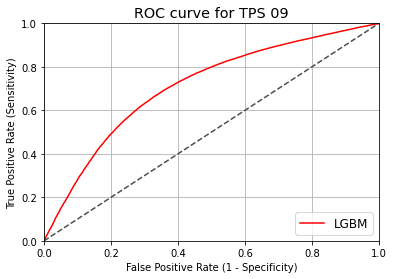

In [133]:
fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_pred_proba)
plot_roc_curve(fpr, tpr, label="LGBM")
plt.show()

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
Observando o gráfico acima, podemos concluir que o melhor ponto de corte (threshold) fica em torno de .4 à .45, isto é, esse ponto de corte melhora o F1-score,  vamos fazer esse teste.  

</div>


- **SEM PONTO DE CORTE**

In [134]:
threshold = .5
y_pred = (y_pred_proba >threshold)

f1_002  = metrics.f1_score (y_valid, y_pred)
auc_002 = metrics.roc_auc_score(y_valid, y_pred)

print(metrics.classification_report(y_valid, y_pred))
print('')
print('F1-score: {:2.5f}'.format(f1_002))
print('AUC     : {:2.5f}'.format(auc_002))

              precision    recall  f1-score   support

           0       0.67      0.63      0.65     59279
           1       0.66      0.70      0.68     60721

    accuracy                           0.67    120000
   macro avg       0.67      0.67      0.67    120000
weighted avg       0.67      0.67      0.67    120000


F1-score: 0.68031
AUC     : 0.66664


- **COM PONTO DE CORTE**

In [135]:
threshold = .49
y_pred  = (y_pred_proba >threshold)
f1_002  = metrics.f1_score (y_valid, y_pred)
auc_002 = metrics.roc_auc_score(y_valid, y_pred)

print(metrics.classification_report(y_valid, y_pred))
print('')
print('F1-score: {:2.5f}'.format(f1_002))
print('AUC     : {:2.5f}'.format(auc_002))

              precision    recall  f1-score   support

           0       0.69      0.58      0.63     59279
           1       0.64      0.75      0.69     60721

    accuracy                           0.66    120000
   macro avg       0.67      0.66      0.66    120000
weighted avg       0.67      0.66      0.66    120000


F1-score: 0.69145
AUC     : 0.66216


<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
Podemos observar acima, com um ponto de corte de .45 obtivemos um F1-score de 0.69162 em relação ao ponto de corte padrão de .5 que gerou um F1-score de 0.66127, uma observação importante que tenho que destacar é que o ponto de corte ideal depende muito do entendimento do negócio que estamos modelando.
 
</div>

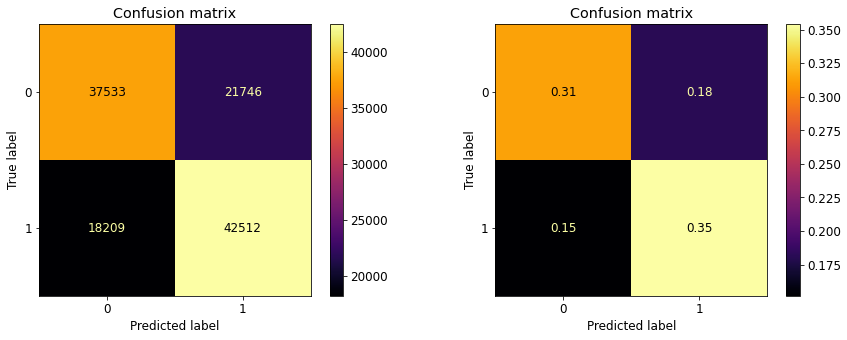

In [136]:
plt.figure(figsize=(15,5))
ax = plt.subplot(1,2,1)

metrics.plot_confusion_matrix(model, 
                              X_valid_scaler, 
                              y_valid, 
                              cmap          = 'inferno', 
                              values_format = 'd', 
                              ax            = ax) #true’, ‘pred’, ‘all’

plt.title('Confusion matrix')

ax= plt.subplot(1,2,2)
metrics.plot_confusion_matrix(model, X_valid_scaler, y_valid, cmap='inferno', normalize='all', ax=ax) 
plt.title('Confusion matrix');

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
com as matrizes de confusão acima podemos ter uma melhor noção para dos número que o modelo consegue gerar na predição, podemos obeservar que o modelo de Random Forest para esse conjunto de dados tem uma taxa razoavel na predição, principalmente na predição de verdadeiro positivo com um percentual de erro de 23%, isto é, o modelo classifica erradamente falsos positivos com sendo verdadeiro posito e acerta 33%, em relação ao falso positivo tem um erro de 17% com certo de 28%.
    
</div>

### 1.2.4. Divercidade

#### 1.2.4.1. Feature Select

#### 1.2.4.1. SEED
Nesta etapa vamos utilizar os melhores parametros, que encontramos na tunagem acima, com `seed` diferentes. 

In [ ]:
%%time 

SEED_       = [42, 59, 100, 200, 1000, 1500, 2020, 2021, 5000, 10000, 7000]
name_model  = name_model_clf + '005_div_seed' 
df_seed     = pd.DataFrame()
params_seed = params_best.copy()

TunningModels.delete_files(name_model)

for i, seed_ in  enumerate (SEED_):     
    
    params_seed.update({'random_state': seed_})
    
    _, score, y_hat, _ = TunningModels.cross_valid(model_         = RandomForestClassifier (**params_best), 
                                                   model_name_    = name_mdl,
                                                   X_train_       = X,
                                                   y_train_       = y, 
                                                   X_test_        = X_test_scaler, 
                                                   fold_          = 5, 
                                                   target_        = 'target',
                                                   path_          = path,
                                                   level_         = '1',
                                                   save_predict_  = True, 
                                                   print_result_  = True,
                                                   seed_          = seed_,
                                                   feature_       = feature_, 
                                                   feature_bin_   = None, 
                                                   scaler_        = scaler_best, 
                                                   threshold      =.5                                                      
                                                   )

    if score > score_best: 
        seed_best  = seed_
        score_best = score

    df_seed['seed_' + str(seed_)] = y_hat 
   
print('Seed best: {}'.format(seed_best))
print('Score    : {:2.5f}'.format(score_best))

Training model: RandomForestClassifier - seed 42 - n_estimators: 772 - max_depth: 9 
Fold: 1 - AUC: 0.66267 - F1-score: 0.67627 - L.Loss: 0.65267 - 0h 11m 47s
Fold: 2 - AUC: 0.66637 - F1-score: 0.67982 - L.Loss: 0.65214 - 0h 11m 40s
Fold: 3 - AUC: 0.66548 - F1-score: 0.67965 - L.Loss: 0.65198 - 0h 11m 26s
Fold: 4 - AUC: 0.66480 - F1-score: 0.67748 - L.Loss: 0.65230 - 0h 11m 53s
Fold: 5 - AUC: 0.66637 - F1-score: 0.68035 - L.Loss: 0.65222 - 0h 11m 42s
--------------------------------------------------------------------------------------------
[Mean Fold]  AUC: 0.66514(Std:0.00137) - F1: 0.67871 - L. Loss: 0.65226  0h 58m 37s

Training model: RandomForestClassifier - seed 59 - n_estimators: 772 - max_depth: 9 
Fold: 1 - AUC: 0.66352 - F1-score: 0.67698 - L.Loss: 0.65268 - 0h 11m 29s
Fold: 2 - AUC: 0.66509 - F1-score: 0.67877 - L.Loss: 0.65214 - 0h 11m 30s
Fold: 3 - AUC: 0.66489 - F1-score: 0.67873 - L.Loss: 0.65233 - 0h 11m 28s
Fold: 4 - AUC: 0.66716 - F1-score: 0.68062 - L.Loss: 0.65213

In [ ]:
 df_seed.head()

In [ ]:
submission = pd.DataFrame({'id': df_submission.id, target: df_seed.mean(axis=1)})
submission.to_csv(path + 'Data/submission/lgbm_005_div_seed.csv', index=False)
# kaggle 0.74514

### 1.2.5. Ensable 

#### 1.2.5.1. Recuparar dataset
Vamos recuperar todas as previsões do LGBM para gerar um ensable. 

In [ ]:
%%time 
df_train, df_test = TunningModels.df_return_preds_tunning(train_shape_row = X.iloc[X_sample_idx].shape[0], 
                                                          test_shape_row  = X_test.shape[0])
print(df_train.shape, df_test.shape)
print()

In [ ]:
df_train.head()

In [ ]:
y_pred      = df_train_rf['target']
df_train_rf = df_train_rf.filter(regex=r'_0.8' , axis=1)
df_test_rf  = df_test_rf.filter(regex=r'_0.8', axis=1)

df_train_rf['target'] = y_pred
df_train_rf.shape, df_test_rf.shape

In [ ]:
df_train_rf.head()

#### 1.2.5.2. Descritiva

In [ ]:
df_test_rf.mean(axis=1).describe()

#### 1.2.5.3. Gerar submission 
Vamos gerar uma submission com a media das previssões, para termos uma ideia de como estamos. 

In [ ]:
y_hat_rf_mean = df_test_rf.mean(axis=1)
submission = pd.DataFrame({'id': df_submission.id, 'claim': y_hat_rf_mean })
submission.to_csv(path + 'Data/sumbmission/rf_003_feature_gr.csv', index=False) 
# score kaggle: 0.60423

In [ ]:
y_hat_rf_mean

#### 1.2.5.4. Correlação

In [ ]:
graf_corr(df_train)

Temos muitas previsões autocorrelacionadas, vamos fazer a exclusão de algumas.

In [ ]:
corr_features = correlation(df_train, 0.75)
len(set(corr_features))

In [ ]:
#df_train_lgbm.drop(labels=corr_features, axis=1, inplace=True)

graf_corr(df_train) 